# SEGY-SAK Basics

**SEGY-SAK** offers a number of utilities to create and load seismic data using `xarray` and `segyio`. In general **SEGY-SAK** uses `xarray.Dataset` to store the data and provides an interface to additional seismic specific functionality by adding the `.segysak` and `.seisio` names-spaces to an `xarray.Dataset` (just `dataset` from now on). That sounds complicated but let us walk through some examples together.

In [1]:
# Disable progress bars for small examples
from segysak.progress import Progress

Progress.set_defaults(disable=True)

## Creating empty 3D geometry

In **segysak** we use the term `seisnc` to refer to a `dataset` which is compatible with **segysak's** functionality and which has the additional names spaces registered with `xarray`, for all intensive purposes it is an `xarray.Dataset` but with defined dimensions and coordinates and some extended functionality. The `seisnc` dimensions are defined depending on what type of seismic it is (2D, 3D, gathers, *etc.*)

To create an empty 3D instance of `seisnc` use the `create3d_dataset`. The function creates a new `seisnc` based upon definitions for the dimensions, `iline` numbering, `xline` numbering and the vertical sampling.

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

from segysak import create3d_dataset

# dims iline, xline, vert
dims = (10, 5, 1000)

new_seisnc = create3d_dataset(
    dims,
    first_iline=1,
    iline_step=2,
    first_xline=10,
    xline_step=1,
    first_sample=0,
    sample_rate=1,
    vert_domain="TWT",
)
new_seisnc

<xarray.Dataset> Size: 8kB
Dimensions:  (iline: 10, xline: 5, twt: 1000)
Coordinates:
  * iline    (iline) int64 80B 1 3 5 7 9 11 13 15 17 19
  * xline    (xline) int64 40B 10 11 12 13 14
  * twt      (twt) int64 8kB 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    *empty*
Attributes: (12/17)
    ns:                  None
    sample_rate:         1
    text:                SEGY-SAK Create 3D Dataset
    measurement_system:  None
    d3_domain:           TWT
    epsg:                None
    ...                  ...
    percentiles:         None
    coord_scalar:        None
    coord_scaled:        None
    dimensions:          None
    vert_dimension:      None
    vert_domain:         None

## Dimension based selection and transformation

As you can see from the print out of the previous cell, we have three dimensions in this dataset. They are `iline`, `xline` and `twt` (although the order, number and names might change depending on the make up of our volume). The ordering isn't import to `xarray` because it uses labels, and accessing data is done using these labels rather than indexing directly into the data like `numpy`. `xarray` also makes it further convenient by allowing us to select based on the dimension values using the `.sel` method with tools for selecting nearest or ranges as well. If necessary you can also select by index using the `.isel` method.

In [3]:
# select iline value 9
xarray_selection = new_seisnc.sel(iline=9)
# select xline value 12
xarray_selection = new_seisnc.sel(xline=12)
# select iline and xline intersection point
xarray_selection = new_seisnc.sel(iline=9, xline=12)
# key error
# xarray_selection = new_seisnc.sel(twt=8.5)
# select nearest twt slice
xarray_selection = new_seisnc.sel(twt=8.5, method="nearest")
# select a range
xarray_selection = new_seisnc.sel(iline=[9, 11, 13])
# select a subcube
# also slices can be used to select ranges as if they were indices!
xarray_selection = new_seisnc.sel(iline=slice(9, 13), xline=[10, 11, 12])
# index selection principles are similar
xarray_selection = new_seisnc.sel(iline=slice(1, 4))

# putting it altogether to extract a sub-cropped horizon slice at odd interval
xarray_selection = new_seisnc.sel(
    twt=8.5, iline=new_seisnc.iline[:4], xline=[10, 12], method="nearest"
)
xarray_selection

<xarray.Dataset> Size: 56B
Dimensions:  (iline: 4, xline: 2)
Coordinates:
  * iline    (iline) int64 32B 1 3 5 7
  * xline    (xline) int64 16B 10 12
    twt      int64 8B 9
Data variables:
    *empty*
Attributes: (12/17)
    ns:                  None
    sample_rate:         1
    text:                SEGY-SAK Create 3D Dataset
    measurement_system:  None
    d3_domain:           TWT
    epsg:                None
    ...                  ...
    percentiles:         None
    coord_scalar:        None
    coord_scaled:        None
    dimensions:          None
    vert_dimension:      None
    vert_domain:         None

## Coordinates Selection

Usually for seismic the X and Y coordinates labelled `cdp_x` and `cdp_y` in seisnc are rotated and scaled relative to the grid geometry and now seisnc dimensions `iline`, `xline` and `twt`. For `xarray` this means you cannot use the `.sel` and `.isel` methods to select data for `cdp_x` and `cdp_y`. **SEGY-SAK** supplies more natural interfaces to access data using X and Y coordinates and this is available through the `.segysak.xysel` method, covered in other examples.

## Adding data to an empty seisnc

Because `xarray` needs to understand the dimensions of any data you assign it must be explicitly communicated either via labels or creating an `xarray.DataArray` first.

In [4]:
# get the dims
dims = new_seisnc.sizes
print(dims)
dkeys = ("xline", "iline", "twt")
dsize = [dims[key] for key in dkeys]
print("keys:", dkeys, "sizes:", dsize)

Frozen({'iline': 10, 'xline': 5, 'twt': 1000})
keys: ('xline', 'iline', 'twt') sizes: [5, 10, 1000]


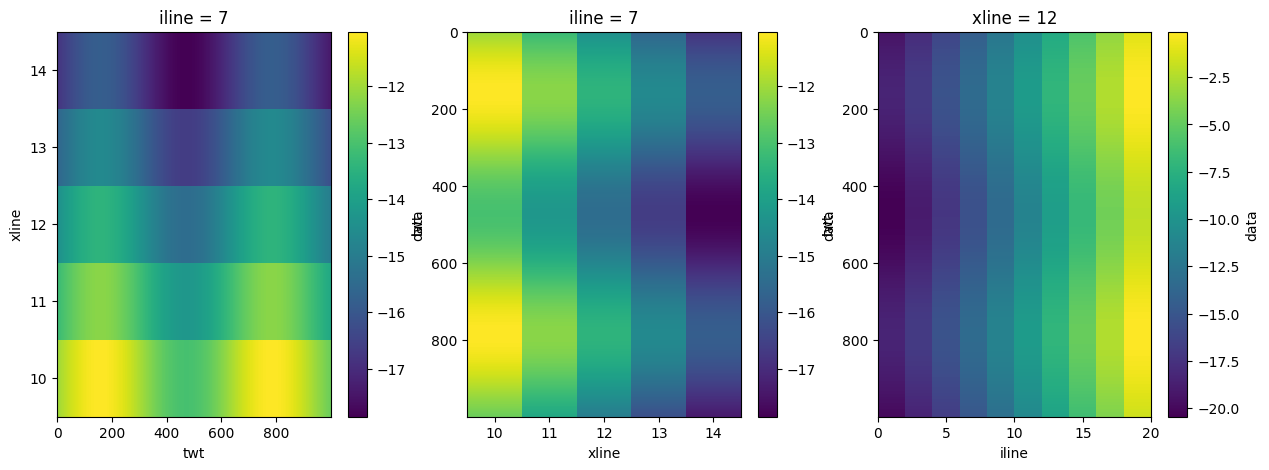

In [5]:
import numpy as np

# create some data and the dimension shapes
xline_, iline_, twt_ = np.meshgrid(new_seisnc.iline, new_seisnc.xline, new_seisnc.twt)
data = np.sin(twt_ / 100) + 2 * iline_ * np.cos(xline_ / 20 + 10)

# assign the data to dataset by passing in a tuple of the dimension keys and the new data
new_seisnc["data"] = (dkeys, data)

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

# axes are wrong for seismic
new_seisnc.data.sel(iline=7).plot(ax=axs[0])

# rotate the cube
new_seisnc.data.transpose("twt", "iline", "xline").sel(iline=7).plot(
    ax=axs[1], yincrease=False
)

# xline is the same?
new_seisnc.data.transpose("twt", "iline", "xline").isel(xline=2).plot(
    ax=axs[2], yincrease=False
)

## Other Useful Methods

Accessing the coordinates or data as a `numpy` array.

In [6]:
# Data can be dropped out of xarray but you then need to manage the coordinates and the dimension
# labels

new_seisnc.iline.values

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])

`xarray.Dataset` and `DataArray` have lots of great built in methods in addition to plot.

In [7]:
print(new_seisnc.data.mean())

<xarray.DataArray 'data' ()> Size: 8B
array(-10.76364169)


In [8]:
print(new_seisnc.data.max())

<xarray.DataArray 'data' ()> Size: 8B
array(0.08882943)


`numpy` functions also work on `xarray` objects but this returns a new `DataArray` not a `ndarray`.

In [9]:
print(np.sum(new_seisnc.data))

<xarray.DataArray 'data' ()> Size: 8B
array(-538182.08430941)


With `xarray` you can apply operations along 1 or more dimensions to reduce the dataset. This could be useful for collapsing gathers for example by applying the mean along the `offset` dimension. Here we combine a `numpy` operation `abs` which returns an `DataArray` and then sum along the time dimension to create a grid without the time dimension.
Along with using masks this is a fundamental building block for performing horizonal sculpting.

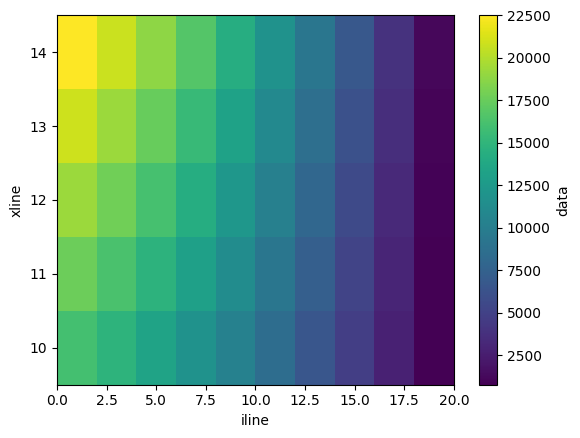

In [10]:
map_data = np.abs(new_seisnc.data).sum(dim="twt")
img = map_data.plot()

Sometimes we need to modify the dimensions because they were read wrong or to scale them. Modify your dimension from the seisnc and then put it back using `assign_coords`.

In [11]:
new_seisnc.assign_coords(iline=new_seisnc.iline * 10, twt=new_seisnc.twt + 1500)

<xarray.Dataset> Size: 408kB
Dimensions:  (xline: 5, iline: 10, twt: 1000)
Coordinates:
  * xline    (xline) int64 40B 10 11 12 13 14
  * iline    (iline) int64 80B 10 30 50 70 90 110 130 150 170 190
  * twt      (twt) int64 8kB 1500 1501 1502 1503 1504 ... 2496 2497 2498 2499
Data variables:
    data     (xline, iline, twt) float64 400kB -16.22 -16.21 ... -1.803 -1.811
Attributes: (12/17)
    ns:                  None
    sample_rate:         1
    text:                SEGY-SAK Create 3D Dataset
    measurement_system:  None
    d3_domain:           TWT
    epsg:                None
    ...                  ...
    percentiles:         None
    coord_scalar:        None
    coord_scaled:        None
    dimensions:          None
    vert_dimension:      None
    vert_domain:         None